# Explore Waves and Conditions

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
plt.rcParams["figure.figsize"] = (14, 7)

In [3]:
df = pd.read_csv("covid_victim.csv").assign(is_70_plus=lambda df: df["age"] >= 70)

In [4]:
df.head().T

,0,1,2,3,4
serial,1,2,3,4,5
age,76,65,74,79,68
condition__blood_pressure,False,False,False,False,False
condition__diabetes,False,False,False,False,False
condition__heart,True,False,True,True,True
condition__lungs,False,False,False,False,False
condition__obesity,False,False,False,False,False
estimated_date,2020-03-20,2020-03-20,2020-03-20,2020-03-22,2020-03-22
is_male,False,False,True,True,True
people_fully_vaccinated,0,0,0,0,0


In [5]:
cond_cols = df.columns[df.columns.str.startswith("condition")]

In [6]:
mean_cols = [
    "positive_rate",
    "total_vaccinations",
    "people_vaccinated",
    "people_fully_vaccinated",
    "total_boosters",
]
sum_cols = [*cond_cols, "is_70_plus", "is_male"]
aggs = {
    **{c: "sum" for c in sum_cols},
    **{c: "mean" for c in mean_cols},
    "count": "sum",
}

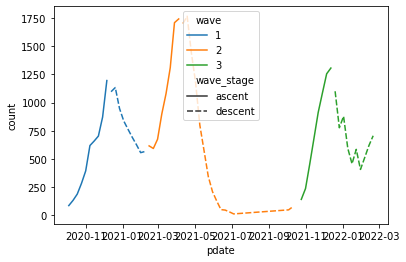

In [7]:
MIN_ASC = 30


def get_wave_n(df):
    wave_ascents = df.groupby("stage")["climb"].mean().loc[lambda s: s > 40].index
    _dic = {a: i + 1 for i, a in enumerate(wave_ascents)}
    wave_dic = {**_dic, **{k + 1: v for k, v in _dic.items()}}
    subseq_waves = pd.Series([wave_dic.get(e, 0) for e in df["stage"]], index=df.index)
    return np.where(
        df["climb"].abs().rolling(4).mean() > (MIN_ASC / 2), subseq_waves, 0
    ).astype(str)


weekly_wave_df = (
    df.assign(count=1, pdate=pd.to_datetime(df["estimated_date"]))
    .groupby("pdate")
    .agg(aggs)
    .resample("1W")
    .agg(aggs)
    .assign(
        climb=lambda df: df["count"].diff(),
        stage=lambda df: (df["climb"] > MIN_ASC)
        .diff()
        .pipe(lambda s: s & (s != s.shift(1)) & (s != s.shift(2)))
        .fillna(0)
        .astype(int)
        .cumsum(),
        wave=get_wave_n,
        wave_stage=lambda df: np.where(
            df.groupby("stage")["climb"].transform("mean") > 0, "ascent", "descent"
        ),
    )
    .loc[lambda df: df["wave"] != "0"]
)

ax = weekly_wave_df.reset_index().pipe(
    lambda df: sns.lineplot(
        x="pdate", y="count", hue="wave", style="wave_stage", data=df
    )
)
plt.show()

In [8]:
changes = (
    weekly_wave_df.loc[:, ["count", *sum_cols]]
    .pipe(lambda df: 2 * df.diff() / (df + df.shift()))
    .fillna(0)
    .pipe(lambda df: df - df[["count"]].values)
    .drop("count", axis=1)
)

In [9]:
(
    pd.concat([changes, weekly_wave_df[["wave", "wave_stage"]]], axis=1)
    .pivot_table(index=["wave", "wave_stage"], values=sum_cols)
    .rename(columns=lambda s: s.replace("condition__", ""))
    .style.background_gradient(
        axis=None,
        vmin=-0.1,
        vmax=0.1,
        cmap=sns.diverging_palette(
            220,
            20,
            as_cmap=True,
        ),
    )
)

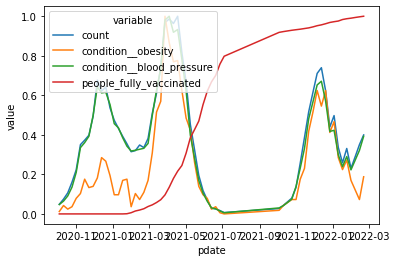

In [10]:
ax = weekly_wave_df.loc[
    :,
    [
        "count",
        "condition__obesity",
        "condition__blood_pressure",
        "people_fully_vaccinated",
    ],
].pipe(lambda df: df / df.max()).melt(ignore_index=False).reset_index().pipe(
    lambda df: sns.lineplot(x="pdate", y="value", hue="variable", data=df)
)

In [11]:
condition_counts = (
    pd.DataFrame(df["raw_conditions"].str.split(", ").tolist())
    .unstack()
    .dropna()
    .value_counts()
)

In [12]:
condition_counts.head(20)

magasvérnyomás-betegség             20589
cukorbetegség                       12811
magas vérnyomás                      8891
iszkémiás szívbetegség               4860
szívbetegség                         3614
demencia                             3022
daganatos megbetegedés               2798
krónikus veseelégtelenség            2299
szívelégtelenség                     2224
veseelégtelenség                     1952
nem ismert alapbetegség              1950
szívritmuszavar                      1890
tüdőbetegség                         1874
érelmeszesedés                       1478
pitvarfibrilláció                    1438
vérszegénység                        1407
kóros elhízás                        1392
krónikus obstruktív tüdőbetegség     1379
elhízás                              1124
asztma                               1109
dtype: int64